# Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling

## Title: Data Acquisition and Data Wrangling for later Prediction of electricity rates (cost/Kwh) and consumption
### Author: Elizabeth Izarra

### General Problem:
Electricity has a very dynamic market price since it is a commodity that is essential for daily life and 
non-storable where generation and demand must be continuously balanced. This is turn make it dependable of the 
weather conditions.    

### Data Sources:

- U.S. Energy Information Administration (EIA)
- National Oceanic and Atmospheric Administration NOAA

### Data Acquisition and Data Wrangling:
The data has to be gotten from different web sources. Each source provides APIs which have to be explored to get the required data for the project.

The data acquisition and data wrangling was divided in the following parts:
   - U.S. Energy Information Administration (EIA): API Exploration, data acquisition and data wrangling in order to get a single view data set of electricity prices, demand, etc by state per month in a year
     
         Findings:
         Each variable series has to be independently fetched per State through APIs. 
     
         Approach:
         All the data by state corresponding to the same variable was fetched in a loop and concatenated while adding  the state information. It was nested in a loop corresponding to all the variables of interest where after fetching each variable, merged them in a single view. 
         The rows that do not correspont to one State were deleted. 
         
         Sample Result:
         See cell Out[11]
     
   - National Oceanic and Atmospheric Adminostration (NOAA): API Exploration, data acquisition and data wrangling of data in order to get a single view data set of temperatures by state per month in a year
   
         Findings:
         Global Monthly Summary series can be fetched per state through APIs. It provides summary data from each station at a State into a time range. Some States have around 350 stations. Nevertheless, the API maximum limit is 1000 records per fetch. 
        
         Approach:
         A couple of loops where nested to fetch data per state per month to cope with the fetching limit. The first loop was used to get the data from all the stations in a State in a month. It was then grouped by date and variables to get the mean of all the stations in the state during that month. The group was unstacked to be able to concatenate with the information of the following month while adding the corresponding State information. This was nested in a per-state loop. 
         
         Sample Result:
         See cell out[24]
        

   - Merging EIA and NOAA Datasets of one year data
          
         Findings:
         The columns ('date' and 'iso3166'/'State') to be used to merge in a single view both data sets had different formats.
         
         Approach:
         - The ISO3166 acronyms for US states with its correspondent states where searched and placed in a csv file. 
         - On the NOAA temperature data set, a column with the corresponding ISO3166 codes was added, as well as, 'date' was formatted to “YYYY-MM-DD’.
         
         - On the EIA data set, the date was formatted to “YYYY-MM-DD’'
         
         - Cleaning functions were defined for both EIA and NOAA data sets.
         
         - Merging of both data sets was done to get a single view of all the data of interest.
         
         Sample Result:
         See cell out[29]

   - Retriving Data from 2001 to 2018: 

           Findings: 
           - NOAA server disconnect after cretain time.
           - EIA doe snot have data available through API previous to 2001
   
           Approach:
           - Getting the data  Year by Year (From 2001 to 2018): 
           The three previous steps (1.- EIA date set acquision per month by state in a year, 2.- NOAA data set Acquisition per month by state in a year, and 3.- Merging of EIA and NOAA data sets) were nested in a loop to get 18 years of data and save them in individuals .csv files per year. See cell In[30] in order to cope with server disconnections.
           - Getting all years of data in a single view: 
           All the yearly .csv file were append to get all the data in one file.
   
   - Data Processing
   
   Checking for missing information: 
           
           Findings:
           - All States were missing "number of accounts' per month for years early to 2008. In addition the state of Alaska also missed the 'monthly customer accounts' in the year 2016.
           
           
           Approach:
           - A .csv file was available in EIA site with the mean annual "number of accounts" for all states. This file was dowloaded and used as a reference for later interpolation of the "number of accounts".
           
   Checking for apparent wrong data
   
           Findings:
           - Net generation is negative in one state 
           
           Approach:
           (I need to find out if it means that the state bought electricity or the data is incorrect) before taking action
           

           
           


### ---------------------------------------------------------------------------------------------------

In [ ]:
# import the relevant modules
import requests
from pandas.io.json import json_normalize
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


### Source: U.S. Energy Information Administration (EIA)

In [2]:
def get_data_from_url(API_query):
    # Package the request, send the request and catch the response: r
    r=requests.get(API_query)

    # Inspect the JSON structure, and exploration of how nested it is,
    # as well as the overall structure

    # Decode the JSON data into a dictionary: json_data
    json_data=r.json()
    return json_data

In [3]:
API_KEY='a32b693a24d623394f601a1c4262fb10'

In [4]:
 #Getting the childcategories into a DataFrame
def get_catID():
   
    #Exploring the available variables
    categoryID='0'
    #Call the EIA API and pull out the data categories
    url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
    json_data=get_data_from_url(url)
    df_cat_IDs_0=json_normalize(json_data['category']['childcategories'])
    return df_cat_IDs_0

In [5]:
get_catID()

category_id                                               name
0             1                                     Net generation
1            32                            Total consumption (Btu)
2            33       Consumption for electricity generation (Btu)
3            34        Consumption for useful thermal output (Btu)
4            35                                  Total consumption
5            36             Consumption for electricity generation
6            37              Consumption for useful thermal output
7            38                        Retail sales of electricity
8            39           Revenue from retail sales of electricity
9            40                Average retail price of electricity
10         1017                                   Plant level data
11        41137      Fossil-fuel stocks for electricity generation
12        41138     Receipts of fossil fuels by electricity plants
13        41139  Receipts of fossil fuels by electricity plants...
14        41140  Average cost of fossil fuels for electricity g...
15        41141  Average cost of fossil fuels for electricity g...
16        41142  Quality of fossil fuels in electricity generat...
17        41143  Quality of fossil fuels in electricity generat...
18      1718389                        Number of customer accounts

In [6]:
    #Checking for childseries availability
    def childseries_check(cat_idx):
        df_cat_IDs_0=get_catID()
        categoryID=str(df_cat_IDs_0.iloc[cat_idx,0]) 
        

        ##API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])
        
        return(df_ser_ID)

In [7]:
#Getting series 

def get_series(idx, f, start, end):
        g=pd.DataFrame()
        df_data_cat=pd.DataFrame()
        df_cat_IDs_0=get_catID()
        categoryID=str(df_cat_IDs_0.iloc[idx,0]) 
        variable=df_cat_IDs_0['name'][idx]
        
        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)
        
        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #getting the series ID for the monthly reporting per state
        #print(f, df_ser_ID.keys())
        ser_IDs=df_ser_ID[df_ser_ID['f'].str.contains(f)]

        #print(ser_IDs.head(), categoryID, variable) 

        #Getting series

        for i in range(len(ser_IDs)):
            #Building API
            seriesID=str(ser_IDs.iloc[i,2]) 
            url='http://api.eia.gov/series/?series_id='+seriesID+'&api_key='+API_KEY+'&start='+start+'&end='+end
            #Retriving data from URL
            json_data=get_data_from_url(url)
           
            #Extracting information of interest
            h1=json_normalize(json_data,['series'])      
            h=json_normalize(json_data,['series',['data']])
             
                  
        
            #Adding names to columns
            
            if not h.empty:
                
                h.columns=['date',variable]
                h['geography']=h1['geography']
                try:h['unit']=h1['units']
                except:h['unit']=''
                try: h['iso3166']=h1['iso3166']
                except:h['iso3166']='N/A'
 
                #Chaging column positions
                g=pd.concat([h['date'],h['geography'],h['iso3166'], h[variable],h['unit']],axis=1)
                
                #Adding missing data
                g.fillna(method='ffill', inplace=True)
                #seriesID, json_data, g

                if i==0:
                    df_data_cat=g
                else:

                    df_data_cat=df_data_cat.append(g, ignore_index=True, sort=False)


            else:
                #print('missing '+ variable+' in year'+start)
                #print(h1.info())
                g['date','geography','iso3166', variable,'unit']='No available'
                df_data_cat=g
            

        return df_data_cat

In [8]:
#Getting data from Energy Information Administration (EIA)


def get_eia_data(variables_idx, f,start, end):
    c_flag=0
    df_cat_IDs_0=get_catID()
    
    for idx in variables_idx:
        variable=df_cat_IDs_0['name'][idx]
        if  childseries_check(idx).empty:
            print('Unavailable -'+variable+': does NOT have childseries')
        else:    
            
            df_data_cat=get_series(idx, f, start, end)
            if df_data_cat.empty:
                print('Unavailable -'+variable+': chilseries does NOT have data')
            else:
                print('Available -'+variable+': - OK')
                if c_flag==0:
                    df=df_data_cat
                    c_flag=1
                    
                else:

                    #Getting the data in a single view
                    df=df.merge(df_data_cat, how='outer', left_on=['date','geography','iso3166'], 
                                          right_on=['date','geography','iso3166'])
    if df_data_cat.empty:
        print(df_data_cat)
    return df
    

In [9]:
#defining a cleaning function to accomodate EIA data set
def cleaning_EIA(df):
    print(df.info())
    #Deleting rows that do not correspont to  one State
    idx=df[df['geography']!=df['iso3166']].index
    df=df.drop(idx, axis=0)
    print('after deleting deleting rows that do not correspont to one State', df.info())
    #Now that 'geography' and column 'iso3166' are the same, we can delete column 'geography'
    df.drop('geography', axis=1, inplace=True)
    print('after deleting geography column', df.info())
    #getting date of EIA data set in proper format to be merged later with EIA data set
    df['date2']=df['date'].apply(lambda dt:'{:%Y-%m-%d}'.format(datetime(int(dt[0:4]), int(dt[4:6]), 1)))
    df['date2']=df['date2'].astype(str)
    print('after adding column date2 with date in proper format', df.head())
    #after inspecting that conversion was suscessful, replacing 'date' with 'date2' and deleting 'date2' column
    df['date']=df['date2']
    df.drop('date2', axis=1, inplace=True)
    #After inspecting, it was found rows with iso3166=USA wich are not of interest (It is relevant only by state)
    #deleting rows with iso3166=USA
    idx=df[df['iso3166']=='USA'].index
    df=df.drop(idx, axis=0)
    return df

#### Getting a Sample Data Set  from EIA for  2013

In [10]:
variables_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] #list of indexes of df_cat_IDs_0
f='M' #Frequency can be 'A':Annual, 'Q':Quarter or 'M':Monthly 
start='2013'
end='2013'
df_data=get_eia_data(variables_idx, f,start, end)
df_data=cleaning_EIA(df_data)
file='Sample_eia_'+start+'_'+end+'.csv'
df_data.to_csv(file)
#df_data.head()


Available -Net generation: - OK
Unavailable -Total consumption (Btu): does NOT have childseries
Unavailable -Consumption for electricity generation (Btu): does NOT have childseries
Unavailable -Consumption for useful thermal output (Btu): does NOT have childseries
Unavailable -Total consumption: does NOT have childseries
Unavailable -Consumption for electricity generation: does NOT have childseries
Unavailable -Consumption for useful thermal output: does NOT have childseries
Available -Retail sales of electricity: - OK
Available -Revenue from retail sales of electricity: - OK
Available -Average retail price of electricity: - OK
Unavailable -Plant level data: does NOT have childseries
Unavailable -Fossil-fuel stocks for electricity generation: does NOT have childseries
Unavailable -Receipts of fossil fuels by electricity plants: does NOT have childseries
Unavailable -Receipts of fossil fuels by electricity plants (Btu): does NOT have childseries
Unavailable -Average cost of fossil fuels

In [11]:
df_data.head()

date iso3166  Net generation                  unit_x  \
0  2013-12-01  USA-AK       649.50352  thousand megawatthours   
1  2013-11-01  USA-AK       564.70533  thousand megawatthours   
2  2013-10-01  USA-AK       568.77441  thousand megawatthours   
3  2013-09-01  USA-AK       503.93265  thousand megawatthours   
4  2013-08-01  USA-AK       499.43930  thousand megawatthours   

   Retail sales of electricity                 unit_y  \
0                    602.36499  million kilowatthours   
1                    526.26297  million kilowatthours   
2                    504.66318  million kilowatthours   
3                    487.79956  million kilowatthours   
4                    503.01620  million kilowatthours   

   Revenue from retail sales of electricity           unit_x  \
0                                 103.67788  million dollars   
1                                  89.28706  million dollars   
2                                  82.52414  million dollars   
3                                  78.83753  million dollars   
4                                  81.24433  million dollars   

   Average retail price of electricity                  unit_y  \
0                                17.21  cents per kilowatthour   
1                                16.97  cents per kilowatthour   
2                                16.35  cents per kilowatthour   
3                                16.16  cents per kilowatthour   
4                                16.15  cents per kilowatthour   

   Number of customer accounts                 unit  
0                       328186  number of customers  
1                       328614  number of customers  
2                       329670  number of customers  
3                       329133  number of customers  
4                       328807  number of customers

### Source: National Oceanic and Atmospheric Administration NOAA

In [12]:
mytoken='AwkqwxasEbHFkzNhMJijIRrdkxVWSkBw'
token = {'token': mytoken}
token

{'token': 'AwkqwxasEbHFkzNhMJijIRrdkxVWSkBw'}

In [13]:
def get_data_from_NOAA(url):
    response = requests.get(url, headers = token) 
    json_data = response.json()
    return json_data

In [14]:
# Exploring all available datasets 
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets'
json_data=get_data_from_NOAA(url)
b=json_normalize(json_data['results'])  
b#json_normalize(json_data['results'])


datacoverage          id     maxdate     mindate  \
0           1.00       GHCND  2019-04-20  1763-01-01   
1           1.00        GSOM  2019-03-01  1763-01-01   
2           1.00        GSOY  2018-01-01  1763-01-01   
3           0.95     NEXRAD2  2019-04-22  1991-06-05   
4           0.95     NEXRAD3  2019-04-15  1994-05-20   
5           1.00  NORMAL_ANN  2010-01-01  2010-01-01   
6           1.00  NORMAL_DLY  2010-12-31  2010-01-01   
7           1.00  NORMAL_HLY  2010-12-31  2010-01-01   
8           1.00  NORMAL_MLY  2010-12-01  2010-01-01   
9           0.25   PRECIP_15  2014-01-01  1970-05-12   
10          1.00  PRECIP_HLY  2014-01-01  1900-01-01   

                           name                   uid  
0               Daily Summaries  gov.noaa.ncdc:C00861  
1   Global Summary of the Month  gov.noaa.ncdc:C00946  
2    Global Summary of the Year  gov.noaa.ncdc:C00947  
3      Weather Radar (Level II)  gov.noaa.ncdc:C00345  
4     Weather Radar (Level III)  gov.noaa.ncdc:C00708  
5       Normals Annual/Seasonal  gov.noaa.ncdc:C00821  
6                 Normals Daily  gov.noaa.ncdc:C00823  
7                Normals Hourly  gov.noaa.ncdc:C00824  
8               Normals Monthly  gov.noaa.ncdc:C00822  
9       Precipitation 15 Minute  gov.noaa.ncdc:C00505  
10         Precipitation Hourly  gov.noaa.ncdc:C00313

In [15]:
#Exploring available monthly data
dataset_id='GSOM'  
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets/'+dataset_id
json_data=get_data_from_NOAA(url)
json_data

{'mindate': '1763-01-01',
 'maxdate': '2019-03-01',
 'name': 'Global Summary of the Month',
 'datacoverage': 1,
 'id': 'GSOM'}

In [16]:
#Fetch all U.S. State ids
def get_stateids_noaa():
    url='https://www.ncdc.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=60'
    json_data=get_data_from_NOAA(url)
    locations_IDs=json_normalize(json_data['results'])    
    locationID_list=list(locations_IDs['id'])
    return locations_IDs
#locationID_list

In [17]:
get_stateids_noaa()

datacoverage       id     maxdate     mindate                  name
0              1  FIPS:01  2019-04-22  1888-02-01               Alabama
1              1  FIPS:02  2019-04-22  1893-09-01                Alaska
2              1  FIPS:04  2019-04-22  1867-08-01               Arizona
3              1  FIPS:05  2019-04-22  1871-07-01              Arkansas
4              1  FIPS:06  2019-04-22  1850-10-01            California
5              1  FIPS:08  2019-04-22  1852-10-01              Colorado
6              1  FIPS:09  2019-04-22  1884-11-01           Connecticut
7              1  FIPS:10  2019-04-22  1893-01-01              Delaware
8              1  FIPS:11  2019-04-22  1870-11-01  District of Columbia
9              1  FIPS:12  2019-04-22  1871-10-01               Florida
10             1  FIPS:13  2019-04-22  1849-01-01               Georgia
11             1  FIPS:15  2019-04-22  1905-01-01                Hawaii
12             1  FIPS:16  2019-04-22  1892-06-01                 Idaho
13             1  FIPS:17  2019-04-22  1870-10-15              Illinois
14             1  FIPS:18  2019-04-22  1886-02-01               Indiana
15             1  FIPS:19  2019-04-22  1888-06-01                  Iowa
16             1  FIPS:20  2019-04-22  1857-04-01                Kansas
17             1  FIPS:21  2019-04-22  1872-10-01              Kentucky
18             1  FIPS:22  2019-04-22  1882-07-01             Louisiana
19             1  FIPS:23  2019-04-22  1885-06-01                 Maine
20             1  FIPS:24  2019-04-22  1880-01-01              Maryland
21             1  FIPS:25  2019-04-22  1831-02-01         Massachusetts
22             1  FIPS:26  2019-04-22  1887-06-01              Michigan
23             1  FIPS:27  2019-04-22  1886-01-01             Minnesota
24             1  FIPS:28  2019-04-22  1891-02-01           Mississippi
25             1  FIPS:29  2019-04-22  1892-04-01              Missouri
26             1  FIPS:30  2019-04-22  1891-08-01               Montana
27             1  FIPS:31  2019-04-22  1878-05-01              Nebraska
28             1  FIPS:32  2019-04-22  1877-07-01                Nevada
29             1  FIPS:33  2019-04-22  1868-01-01         New Hampshire
30             1  FIPS:34  2019-04-22  1865-06-01            New Jersey
31             1  FIPS:35  2019-04-22  1870-01-01            New Mexico
32             1  FIPS:36  2019-04-22  1869-01-01              New York
33             1  FIPS:37  2019-04-22  1869-03-01        North Carolina
34             1  FIPS:38  2019-04-22  1891-07-01          North Dakota
35             1  FIPS:39  2019-04-22  1878-02-01                  Ohio
36             1  FIPS:40  2019-04-22  1870-04-01              Oklahoma
37             1  FIPS:41  2019-04-22  1871-11-01                Oregon
38             1  FIPS:42  2019-04-22  1849-04-01          Pennsylvania
39             1  FIPS:44  2019-04-22  1893-01-01          Rhode Island
40             1  FIPS:45  2019-04-22  1849-05-01        South Carolina
41             1  FIPS:46  2019-04-22  1893-01-01          South Dakota
42             1  FIPS:47  2019-04-22  1879-01-01             Tennessee
43             1  FIPS:48  2019-04-22  1852-04-01                 Texas
44             1  FIPS:49  2019-04-22  1887-12-01                  Utah
45             1  FIPS:50  2019-04-22  1883-12-01               Vermont
46             1  FIPS:51  2019-04-22  1869-01-01              Virginia
47             1  FIPS:53  2019-04-22  1856-01-01            Washington
48             1  FIPS:54  2019-04-22  1854-01-01         West Virginia
49             1  FIPS:55  2019-04-22  1871-01-01             Wisconsin
50             1  FIPS:56  2019-04-22  1889-01-01               Wyoming

In [18]:
#Exploring Datatypes from Global Summanary of Month Dataset GSOM
dataset_id='GSOM'
location_id='FIPS:01'
start_date='2013-01-01'
end_date='2013-01-31'
limit='1000'
units='standard'
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset_id+'&locationid='+location_id+'&units='+units+'&startdate='+start_date+'&enddate='+end_date+'&limit='+limit
json_data=get_data_from_NOAA(url)
a=json_normalize(json_data['results'])  
a.groupby(by=['date','datatype'])['value'].mean()

date                 datatype
2013-01-01T00:00:00  CDSD           7.200000
                     CLDD           7.200000
                     DP01          13.800000
                     DP10           9.677778
                     DP1X           2.550000
                     DSND           0.000000
                     DSNW           0.000000
                     DT00           0.000000
                     DT32          14.800000
                     DX32           0.000000
                     DX70           4.800000
                     DX90           0.000000
                     EMNT          24.400000
                     EMSD           0.000000
                     EMSN           0.060000
                     EMXP           1.859274
                     EMXT          75.000000
                     HDSD        1557.250000
                     HTDD         495.000000
                     PRCP           7.229050
                     SNOW           0.060000
                     TAVG

In [19]:
#getting Data from National Oceanic and Atmospheric Administration NOAA
def get_noaa_data2(dataset_id, datatype_id, limit, units, st_year, end_year):
    df_temperatures=pd.DataFrame()
    locations_IDs=get_stateids_noaa()
    #start_date='{:%Y-%m-%d}'.format(datetime(st_year, 1, 1))
    #end_date='{:%Y-%m-%d}'.format(datetime(end_year, 12, 1))
   
    #This API provides the data from all the stations per state per month
    #Some states have around 350 stations, and the API limit is 1000 records per fetch. 
    #It means we would have to fetch the data per state per month in order to get all the data

    l_dates=list()
    for y in range(st_year,end_year+1):
        for m in range(1,13):
            l_dates.append('{:%Y-%m-%d}'.format(datetime(y, m, 1)))
    

    for location in locations_IDs.values:
        #print(location)
        location_id=location[1]
        state=location[4]

            
       
        for start_date in l_dates: 
            end_date=start_date
            url='https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset_id+'&locationid='+location_id+'&datatypeid='+datatype_id+'&units='+units+'&startdate='+start_date+'&enddate='+end_date+'&limit='+limit
            json_data=get_data_from_NOAA(url)
            #print(json_data)
            a=json_normalize(json_data['results'])  


            #Getting the mean from all the stations in the state per requested datatype
            a=a.groupby(by=['date','datatype'])['value'].mean()

            #Getting the temperatures data in a single view
            a=a.unstack()     
            a['state']=state
            df_temperatures=df_temperatures.append(a, ignore_index=False, sort=False)
            
            
    df_temperatures=df_temperatures.reset_index()
    return df_temperatures

In [20]:
def cleaning_NOAA(df):
    #getting the iso3166 codes for US States
    file='ISO3166.csv' #file with US ISO3166 codes
    df_iso3166 = pd.read_csv(file,sep=',')
    df_iso3166.head()
    
    #getting the iso3166 code with 'USA' instead 'US' as used in the EIA data set
    df_iso3166['iso3166']=df_iso3166['iso3166'].apply(lambda iso: iso[0:2]+'A'+iso[2:])
    df_iso3166.head()
    
    #Adding the quivalent iso3166 code to the EIA data set
    df['iso3166']=''
    for iso in df_iso3166.values:
        df_index=df[df['state']==iso[1]]['iso3166'].index
        df.iloc[df_index,5]=iso[0]
    print('after adding iso3166 column', df.head())

    #getting date of NOAA data set in proper format
    df['date2']=pd.to_datetime(df['date'] )
    df['date2']=df['date2'].astype(str)
    print('after adding column date2 withe the date proper format',df.head())
    
    #after inspecting that conversion was suscessful, replacing 'date' with 'date2' and deleting 'date2' column
    df['date']=df['date2']
    df.drop('date2', axis=1, inplace=True)
    
    
    return df


#### Getting a Sample Data Set from NOAA for 2013

In [21]:
#Fetching selected Datatypes from Global Summary of Month Dataset GSOM
dataset_id='GSOM'
datatype_id='TAVG, TMAX, TMIN'
limit='1000' #1000 is the higher limit accepted by the APY
units='standard'
st_year=2013
end_year=2013

df_data_NOAA=get_noaa_data2(dataset_id, datatype_id, limit, units, st_year,end_year)
df_data_NOAA=cleaning_NOAA(df_data_NOAA)

file='Sample_noaa_'+str(st_year)+'_'+str(end_year)+'.csv'
df_data_NOAA.to_csv(file)

after adding iso3166 column datatype                 date       TAVG       TMAX       TMIN    state  \
0         2013-01-01T00:00:00  49.604348  59.304310  39.854783  Alabama   
1         2013-02-01T00:00:00  47.433913  58.216379  36.712069  Alabama   
2         2013-03-01T00:00:00  49.392793  61.686842  37.068468  Alabama   
3         2013-04-01T00:00:00  62.018966  73.966379  50.066379  Alabama   
4         2013-05-01T00:00:00  67.977477  79.181982  56.775676  Alabama   

datatype iso3166  
0         USA-AL  
1         USA-AL  
2         USA-AL  
3         USA-AL  
4         USA-AL  
after adding column date2 withe the date proper format datatype                 date       TAVG       TMAX       TMIN    state  \
0         2013-01-01T00:00:00  49.604348  59.304310  39.854783  Alabama   
1         2013-02-01T00:00:00  47.433913  58.216379  36.712069  Alabama   
2         2013-03-01T00:00:00  49.392793  61.686842  37.068468  Alabama   
3         2013-04-01T00:00:00  62.018966  73.966379 

In [22]:
df_data_NOAA.head()

datatype        date       TAVG       TMAX       TMIN    state iso3166
0         2013-01-01  49.604348  59.304310  39.854783  Alabama  USA-AL
1         2013-02-01  47.433913  58.216379  36.712069  Alabama  USA-AL
2         2013-03-01  49.392793  61.686842  37.068468  Alabama  USA-AL
3         2013-04-01  62.018966  73.966379  50.066379  Alabama  USA-AL
4         2013-05-01  67.977477  79.181982  56.775676  Alabama  USA-AL

### Merging NOAA and EIA Sample data sets

In [23]:
def check_year_data(df, source, year):
    a=df.groupby(by='iso3166')['iso3166'].count()
    if len(a)==51:
        if(a.sum()==612):
            print(source+' year '+str(year)+' - ' +str(len(a))+ ' states reported')
        else:
            print(source+ ' year '+str(year)+' - States with less than 12 month reported')
    else: print(source+' year '+str(year)+' - Check number of states reported ' + str(len(a)) )

In [25]:
check_year_data(df_data, 'EIA',st_year)
check_year_data(df_data_NOAA, 'NOAA', st_year)
#Getting all the data in a single view
df_data_all=df_data.merge(df_data_NOAA, how='outer', left_on=['date', 'iso3166'], right_on=['date', 'iso3166'])
df_data_all.head()
file='Sample_data_all_'+str(st_year)+'_'+str(end_year)+'.csv'
df_data_all.to_csv(file)

EIA year 2013 - 51 states reported
NOAA year 2013 - 51 states reported


In [26]:
df_data_all.head()

date iso3166  Net generation                  unit_x  \
0  2013-12-01  USA-AK       649.50352  thousand megawatthours   
1  2013-11-01  USA-AK       564.70533  thousand megawatthours   
2  2013-10-01  USA-AK       568.77441  thousand megawatthours   
3  2013-09-01  USA-AK       503.93265  thousand megawatthours   
4  2013-08-01  USA-AK       499.43930  thousand megawatthours   

   Retail sales of electricity                 unit_y  \
0                    602.36499  million kilowatthours   
1                    526.26297  million kilowatthours   
2                    504.66318  million kilowatthours   
3                    487.79956  million kilowatthours   
4                    503.01620  million kilowatthours   

   Revenue from retail sales of electricity           unit_x  \
0                                 103.67788  million dollars   
1                                  89.28706  million dollars   
2                                  82.52414  million dollars   
3                                  78.83753  million dollars   
4                                  81.24433  million dollars   

   Average retail price of electricity                  unit_y  \
0                                17.21  cents per kilowatthour   
1                                16.97  cents per kilowatthour   
2                                16.35  cents per kilowatthour   
3                                16.16  cents per kilowatthour   
4                                16.15  cents per kilowatthour   

   Number of customer accounts                 unit       TAVG       TMAX  \
0                       328186  number of customers   9.813636  15.951916   
1                       328614  number of customers  16.774832  23.336242   
2                       329670  number of customers  37.258249  42.963758   
3                       329133  number of customers  42.921649  49.683505   
4                       328807  number of customers  54.005455  62.089855   

        TMIN   state  
0   3.764111  Alaska  
1  10.168227  Alaska  
2  31.572727  Alaska  
3  36.157732  Alaska  
4  46.001091  Alaska

### Retriving Data from 2001 to 2018

In [ ]:
start_year=2001
end_year=2018
df_data_EIA=pd.DataFrame()
df_data_NOAA=pd.DataFrame()
df_data_all=pd. DataFrame()

#getting data per month Year by Year
for y in range(start_year,end_year+1):
    #Getting EIA data
    variables_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] #list of indexes of df_cat_IDs_0
    f='M' #Frequency can be 'A':Annual, 'Q':Quarter or 'M':Monthly 
    start=str(y)
    end=str(y)
    df_data_EIA=get_eia_data(variables_idx, f,start, end)
    df_data_EIA=cleaning_EIA(df_data_EIA)
    file='eia_'+start+'_'+end+'.csv'
    df_data_EIA.to_csv(file)
    #df_data.head()

    ##Getting NOAA data
    #Fetching selected Datatypes from Global Summary of Month Dataset GSOM
    dataset_id='GSOM'
    datatype_id='TAVG, TMAX, TMIN'
    limit='1000' #1000 is the higher limit accepted by the APY
    units='standard'
    int_st_year=y
    int_end_year=y

    df_data_NOAA=get_noaa_data2(dataset_id, datatype_id, limit, units, int_st_year,int_end_year)
    df_data_NOAA=cleaning_NOAA(df_data_NOAA)

    file='noaa_'+str(int_st_year)+'_'+str(int_end_year)+'.csv'
    df_data_NOAA.to_csv(file)

    #Merging data sets
    check_year_data(df_data_EIA, 'EIA', y)
    check_year_data(df_data_NOAA, 'NOAA',y)
    #Getting all the data in a single view
    df_data_all=df_data_EIA.merge(df_data_NOAA, how='outer', left_on=['date', 'iso3166'], right_on=['date', 'iso3166'])
    df_data_all.head()
    file='data_all_'+str(int_st_year)+'_'+str(int_end_year)+'.csv'
    df_data_all.to_csv(file)
    
    

In [ ]:
#Getting all years of data in a single view
start_year=2001
end_year=2018
df_year=pd.DataFrame()
df_all=pd.DataFrame()
i_flag=0
for y in range(end_year, start_year-1, -1):
    file='data_all_'+str(y)+'_'+str(y)+'.csv'
    df_year=pd.read_csv(file)
    if i_flag==0:
        df_all=df_year
        i_flag=1
    else:
        df_all=df_all.append(df_year, sort=False, ignore_index=True)
    

df_all.to_csv('AllData_1.csv')

### Data Processing:

In [27]:
#get the data multi-indexed and sorted: tuple ('date', 'state') as index. Sorted by 'date'

#possible values for str_idx2: 'state' or 'iso3166'. By default state
def get_data_muti_indexed(df, str_idx2='state'):
    df['date']=pd.to_datetime(df['date'], format="%Y-%m-%d")
    df=df.set_index(['date', str_idx2])
    df = df.sort_values(by=['date','state'],ascending=[True,False])
    
    return df

#Example to slice Multi-indexed data
#Slice to get the state of Älaska from 2015-12-01 to 2017-01-01
#c.loc[(pd.IndexSlice['2015-12-01':'2017-01-01'], 'Alaska'), slice(None)]

In [28]:
#get the time series of one variable: date as index, States as columns, variable as values 

#possible values for str_idx2: 'state' or 'iso3166'. By default state
def get_variable_stateincolumns(df, str_variable, str_idx2='state'):
    #df['date']=pd.to_datetime(df['date'], format="%Y-%m-%d")
    #df=df.set_index(['date', 'state'])
    df=get_data_muti_indexed(df, str_idx2)
    df=df[str_variable]
    df=df.unstack()
    return df

In [29]:
#Resampling the existing data to get the mean annual
def variable_anual_mean(df, variable):
    
    #get the time series of one variable: date as index, States as columns, variable as values 
    df_c=get_variable_stateincolumns(df, variable, str_idx2='iso3166')

    
    df_variable_annual=df_c.resample('Y').mean()
    
    return df_variable_annual

In [30]:
#Plotting Variable in scatter plot to visualize data
def plot_scatter_variable_all_states(df,variable):
    #get the time series of one variable: date as index, States as columns, variable as values 
    
    c=get_variable_stateincolumns(df, variable)
    i=1
    for state in c.columns:
        x=c.index.values
        y=c[state]

        #Format the size of the figure/plot
        width=12
        height=4.8
        plt.rcParams['figure.figsize'] = [width, height]

        plt.scatter(x=x, y=y, label=state, s=1)
        
        plt.xlabel('date')
        plt.title(variable+'- All States')
        plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc='best', ncol=5, mode="expand")
        plt.xlim('2001-01-01', '2018-12-31')
        plt.yscale('log')
        
        i+=i
        
    plt.show()
    plt.clf()
    plt.rcdefaults() #restore plot default values

In [31]:
#Plotting Variable in line plot to visualize data
def plot_variable_all_states(df,variable):

    #get the time series of one variable: date as index, States as columns, variable as values 
    c=get_variable_stateincolumns(df, variable)

    #Format the size of the figure/plot
    width=12
    height=4.8
    plt.rcParams['figure.figsize'] = [width, height]
    plt.rcParams['lines.linewidth'] = 1
    
    #Plotting variable for all states 
    c.plot()
    plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc='best', ncol=5, mode="expand", borderaxespad=0)
    plt.xlabel('date')
    plt.title(variable+'- All States')
    plt.xlim('2001-01-01', '2018-12-31')
    plt.yscale('log')
    
    
    
    plt.show()
    plt.clf()
    plt.rcdefaults() #restore plot default values

In [32]:
#Getting the data from 2001 to 2018
df_all=pd.read_csv('AllData_1.csv')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
Unnamed: 0                                  11016 non-null int64
Unnamed: 0.1                                11016 non-null int64
date                                        11016 non-null object
iso3166                                     11016 non-null object
Net generation                              11016 non-null float64
unit_x                                      11016 non-null object
Retail sales of electricity                 11016 non-null float64
unit_y                                      11016 non-null object
Revenue from retail sales of electricity    11015 non-null float64
unit_x.1                                    11016 non-null object
Average retail price of electricity         11016 non-null float64
unit_y.1                                    11016 non-null object
Number of customer accounts                 6720 non-null float64
unit                           

In [33]:
#checking for missing information
for variable in df_all.columns:
    idx=df_all.index[df_all[variable].isnull()]
    if idx.empty:
        print('data complete: '+ variable)
    else:
        #finding all rows missing data
        missing_rows=df_all.iloc[idx, slice(None)]
        print('missing data ('+str(len(missing_rows))+' missing): '+variable)
    

data complete: Unnamed: 0
data complete: Unnamed: 0.1
data complete: date
data complete: iso3166
data complete: Net generation
data complete: unit_x
data complete: Retail sales of electricity
data complete: unit_y
missing data (1 missing): Revenue from retail sales of electricity
data complete: unit_x.1
data complete: Average retail price of electricity
data complete: unit_y.1
missing data (4296 missing): Number of customer accounts
missing data (4284 missing): unit
data complete: TAVG
data complete: TMAX
data complete: TMIN
data complete: state


In [34]:
#Inspecting to see what states are missing 'Number of customers accounts'
variable='Number of customer accounts'
idx=df_all.index[df_all[variable].isnull()]
missing_rows=df_all.iloc[idx, slice(None)]
missing_rows.groupby(by=['state']).count()

Unnamed: 0  Unnamed: 0.1  date  iso3166  Net generation  \
state                                                                           
Alabama                       84            84    84       84              84   
Alaska                        96            96    96       96              96   
Arizona                       84            84    84       84              84   
Arkansas                      84            84    84       84              84   
California                    84            84    84       84              84   
Colorado                      84            84    84       84              84   
Connecticut                   84            84    84       84              84   
Delaware                      84            84    84       84              84   
District of Columbia          84            84    84       84              84   
Florida                       84            84    84       84              84   
Georgia                       84            84    84       84              84   
Hawaii                        84            84    84       84              84   
Idaho                         84            84    84       84              84   
Illinois                      84            84    84       84              84   
Indiana                       84            84    84       84              84   
Iowa                          84            84    84       84              84   
Kansas                        84            84    84       84              84   
Kentucky                      84            84    84       84              84   
Louisiana                     84            84    84       84              84   
Maine                         84            84    84       84              84   
Maryland                      84            84    84       84              84   
Massachusetts                 84            84    84       84              84   
Michigan                      84            84    84       84              84   
Minnesota                     84            84    84       84              84   
Mississippi                   84            84    84       84              84   
Missouri                      84            84    84       84              84   
Montana                       84            84    84       84              84   
Nebraska                      84            84    84       84              84   
Nevada                        84            84    84       84              84   
New Hampshire                 84            84    84       84              84   
New Jersey                    84            84    84       84              84   
New Mexico                    84            84    84       84              84   
New York                      84            84    84       84              84   
North Carolina                84            84    84       84              84   
North Dakota                  84            84    84       84              84   
Ohio                          84            84    84       84              84   
Oklahoma                      84            84    84       84              84   
Oregon                        84            84    84       84              84   
Pennsylvania                  84            84    84       84              84   
Rhode Island                  84            84    84       84              84   
South Carolina                84            84    84       84              84   
South Dakota                  84            84    84       84              84   
Tennessee                     84            84    84       84              84   
Texas                         84            84    84       84              84   
Utah                          84            84    84       84              84   
Vermont                       84            84    84       84              84   
Virginia                      84            84    84       84              84   
Washington                    84            84    84 

In [35]:
#inspecting the statistics of the variable 'Number of customer accounts' per state

#get the time series of one variable: date as index, States as columns, variable as values 
variable='Number of customer accounts'
c=get_variable_stateincolumns(df_all, variable)

c.describe()

state       Alabama         Alaska       Arizona      Arkansas    California  \
count  1.320000e+02     120.000000  1.320000e+02  1.320000e+02  1.320000e+02   
mean   2.538588e+06  328692.283333  2.958643e+06  1.563281e+06  1.508122e+07   
std    4.527957e+04    9126.398056  9.797357e+04  3.657353e+04  3.777191e+05   
min    2.481578e+06  314857.000000  2.825357e+06  1.507790e+06  1.410021e+07   
25%    2.503585e+06  321348.000000  2.870518e+06  1.532333e+06  1.479484e+07   
50%    2.523828e+06  326175.000000  2.944620e+06  1.553160e+06  1.507832e+07   
75%    2.568839e+06  336372.250000  3.040535e+06  1.599046e+06  1.533827e+07   
max    2.645983e+06  346805.000000  3.159483e+06  1.634390e+06  1.587646e+07   

state      Colorado   Connecticut       Delaware  District of Columbia  \
count  1.320000e+02  1.320000e+02     132.000000            132.000000   
mean   2.571275e+06  1.623282e+06  459765.962121         267310.810606   
std    7.391535e+04  2.062424e+04   14413.569392          18088.432929   
min    2.469681e+06  1.572803e+06  438888.000000         242296.000000   
25%    2.508078e+06  1.609702e+06  447673.500000         254340.500000   
50%    2.549818e+06  1.614295e+06  455953.500000         261439.500000   
75%    2.633301e+06  1.642069e+06  471880.000000         283475.250000   
max    2.722392e+06  1.665746e+06  487408.000000         305487.000000   

state       Florida      ...         South Dakota     Tennessee         Texas  \
count  1.320000e+02      ...           132.000000  1.320000e+02  1.320000e+02   
mean   1.002178e+07      ...        454328.000000  3.231337e+06  1.159924e+07   
std    3.650082e+05      ...         14848.268838  7.594280e+04  5.450461e+05   
min    9.530442e+06      ...        426451.000000  3.133081e+06  1.096543e+07   
25%    9.673130e+06      ...        441860.500000  3.168107e+06  1.110034e+07   
50%    9.955748e+06      ...        455018.000000  3.213498e+06  1.141239e+07   
75%    1.035386e+07      ...        465059.250000  3.284108e+06  1.204116e+07   
max    1.078585e+07      ...        482567.000000  3.406391e+06  1.273382e+07   

state          Utah        Vermont      Virginia    Washington  West Virginia  \
count  1.320000e+02     132.000000  1.320000e+02  1.320000e+02   1.320000e+02   
mean   1.119999e+06  363297.977273  3.715539e+06  3.294366e+06   1.015363e+06   
std    5.495373e+04    5343.699351  9.368680e+04  1.039640e+05   2.465852e+03   
min    1.045302e+06  354549.000000  3.530445e+06  3.139184e+06   1.009903e+06   
25%    1.071366e+06  358726.750000  3.634802e+06  3.204862e+06   1.013640e+06   
50%    1.106967e+06  362923.500000  3.715950e+06  3.266059e+06   1.015427e+06   
75%    1.170529e+06  367361.000000  3.793427e+06  3.364905e+06   1.017156e+06   
max    1.220991e+06  374457.000000  3.892180e+06  3.510845e+06   1.025529e+06   

state     Wisconsin        Wyoming  
count  1.320000e+02     132.000000  
mean   2.979754e+06  331860.681818  
std    4.923315e+04    6752.614588  
min    2.907104e+06  317175.000000  
25%    2.942521e+06  326304.750000  
50%    2.966932e+06  331718.000000  
75%    3.014344e+06  337403.000000  
max    3.097025e+06  344149.000000  

[8 rows x 51 columns]

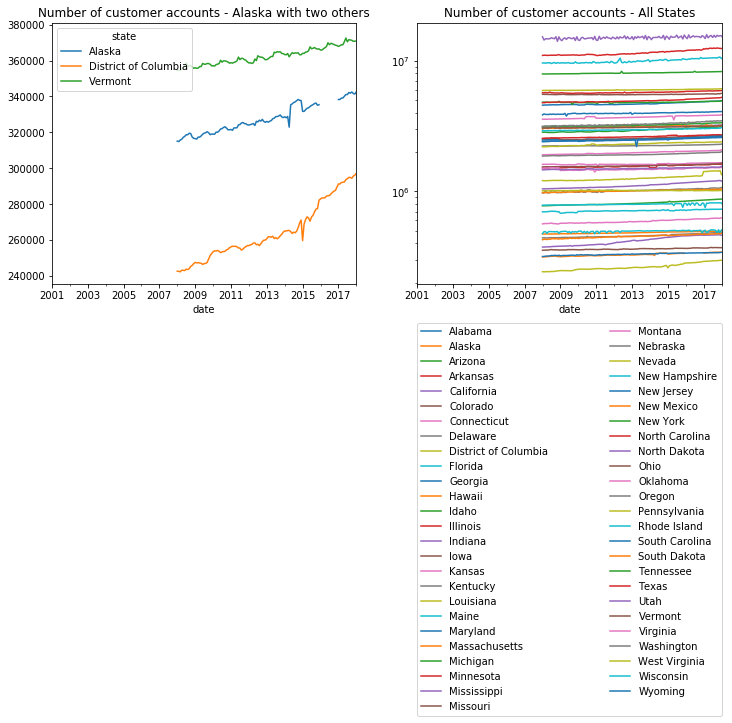

In [36]:
#Plotting "Number of customer accounts" to visualize missing data

#get the time series of one variable: date as index, States as columns, variable as values 
variable='Number of customer accounts'
c=get_variable_stateincolumns(df_all, variable)

#Format the size of the figure/plot
width=12
height=4.8
plt.rcParams['figure.figsize'] = [width, height]

# This formats the subplots
fig, axes = plt.subplots(nrows=1, ncols=2)

#Plotting "Number of customer account" for all states 
c.plot(ax=axes[1], logy=True, xlim=('2001','2018'), title=variable+ ' - All States')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=1, ncol=2, mode="expand", borderaxespad=0)


#Plotting "Number of customer account" for the state of 'Alaska' together with two others similar account size to visualize missing data
c.loc[slice(None),['Alaska', 'District of Columbia', 'Vermont']].plot(ax=axes[0], logy=False, xlim=('2001','2018'), title=variable+' - Alaska with two others')

plt.show(fig)

plt.rcdefaults() #restore plot default values


In [37]:
#Checking missing data in 2016 for the state of Alaska

#get the data multi-indexed and sorted: tuple ('date', 'state') as index. Sorted by 'date'
c=get_data_muti_indexed(df_all)

#Slice to get the state of Älaska from 2015-12-01 to 2017-01-01
c.loc[(pd.IndexSlice['2015-12-01':'2017-01-01'], 'Alaska'), slice(None)]


Unnamed: 0  Unnamed: 0.1 iso3166  Net generation  \
date       state                                                      
2015-12-01 Alaska        1836             0  USA-AK       598.96660   
2016-01-01 Alaska        1235            11  USA-AK       596.75576   
2016-02-01 Alaska        1234            10  USA-AK       547.81802   
2016-03-01 Alaska        1233             9  USA-AK       575.82951   
2016-04-01 Alaska        1232             8  USA-AK       489.54473   
2016-05-01 Alaska        1231             7  USA-AK       449.66508   
2016-06-01 Alaska        1230             6  USA-AK       445.19996   
2016-07-01 Alaska        1229             5  USA-AK       479.00506   
2016-08-01 Alaska        1228             4  USA-AK       508.56639   
2016-09-01 Alaska        1227             3  USA-AK       523.61710   
2016-10-01 Alaska        1226             2  USA-AK       519.56652   
2016-11-01 Alaska        1225             1  USA-AK       569.36559   
2016-12-01 Alaska        1224             0  USA-AK       630.09979   
2017-01-01 Alaska         623            11  USA-AK       672.30106   

                                   unit_x  Retail sales of electricity  \
date       state                                                         
2015-12-01 Alaska  thousand megawatthours                    587.95367   
2016-01-01 Alaska  thousand megawatthours                    577.08262   
2016-02-01 Alaska  thousand megawatthours                    534.75130   
2016-03-01 Alaska  thousand megawatthours                    526.81980   
2016-04-01 Alaska  thousand megawatthours                    480.16147   
2016-05-01 Alaska  thousand megawatthours                    468.77657   
2016-06-01 Alaska  thousand megawatthours                    462.12759   
2016-07-01 Alaska  thousand megawatthours                    473.04622   
2016-08-01 Alaska  thousand megawatthours                    494.17691   
2016-09-01 Alaska  thousand megawatthours                    470.27145   
2016-10-01 Alaska  thousand megawatthours                    506.26737   
2016-11-01 Alaska  thousand megawatthours                    534.24663   
2016-12-01 Alaska  thousand megawatthours                    595.47410   
2017-01-01 Alaska  thousand megawatthours                    606.48769   

                                  unit_y  \
date       state                           
2015-12-01 Alaska  million kilowatthours   
2016-01-01 Alaska  million kilowatthours   
2016-02-01 Alaska  million kilowatthours   
2016-03-01 Alaska  million kilowatthours   
2016-04-01 Alaska  million kilowatthours   
2016-05-01 Alaska  million kilowatthours   
2016-06-01 Alaska  million kilowatthours   
2016-07-01 Alaska  million kilowatthours   
2016-08-01 Alaska  million kilowatthours   
2016-09-01 Alaska  million kilowatthours   
2016-10-01 Alaska  million kilowatthours   
2016-11-01 Alaska  million kilowatthours   
2016-12-01 Alaska  million kilowatthours   
2017-01-01 Alaska  million kilowatthours   

                   Revenue from retail sales of electricity         unit_x.1  \
date       state                                                               
2015-12-01 Alaska                                  99.15691  million dollars   
2016-01-01 Alaska                                  92.42892  million dollars   
2016-02-01 Alaska                                  92.42892  million dollars   
2016-03-01 Alaska                                  92.42892  million dollars   
2016-04-01 Alaska                                  92.42892  million dollars   
2016-05-01 Alaska                                  92.42892  million dollars   
2016-06-01 Alaska                                  92.42892  million dollars   
2016-07-01 Alaska                                  92.42892  million dollars   
2016-08-01 Alaska                                  92.42892  million dollars   
2016-09-01 Alaska                                  92.42892  million dollars   
2016-10-01 Alaska               

In [38]:
#getting the annual mean of the variable 'Number of customer accounts'
variable='Number of customer accounts'
variable_anual_mean(df_all, variable)

iso3166            USA-AK        USA-AL        USA-AR        USA-AZ  \
date                                                                  
2001-12-31            NaN           NaN           NaN           NaN   
2002-12-31            NaN           NaN           NaN           NaN   
2003-12-31            NaN           NaN           NaN           NaN   
2004-12-31            NaN           NaN           NaN           NaN   
2005-12-31            NaN           NaN           NaN           NaN   
2006-12-31            NaN           NaN           NaN           NaN   
2007-12-31            NaN           NaN           NaN           NaN   
2008-12-31  317244.166667  2.491147e+06  1.516551e+06  2.834064e+06   
2009-12-31  318458.750000  2.491143e+06  1.524432e+06  2.851114e+06   
2010-12-31  321149.666667  2.502109e+06  1.534202e+06  2.861857e+06   
2011-12-31  323601.666667  2.505192e+06  1.541338e+06  2.888134e+06   
2012-12-31  325454.666667  2.515540e+06  1.547902e+06  2.898624e+06   
2013-12-31  327759.916667  2.524633e+06  1.557321e+06  2.947070e+06   
2014-12-31  333729.750000  2.537922e+06  1.566533e+06  2.981620e+06   
2015-12-31  334221.666667  2.552739e+06  1.580231e+06  3.011739e+06   
2016-12-31            NaN  2.574851e+06  1.595478e+06  3.051838e+06   
2017-12-31  340541.916667  2.591621e+06  1.607633e+06  3.093045e+06   
2018-12-31  344760.666667  2.637577e+06  1.624469e+06  3.125970e+06   

iso3166           USA-CA        USA-CO        USA-CT         USA-DC  \
date                                                                  
2001-12-31           NaN           NaN           NaN            NaN   
2002-12-31           NaN           NaN           NaN            NaN   
2003-12-31           NaN           NaN           NaN            NaN   
2004-12-31           NaN           NaN           NaN            NaN   
2005-12-31           NaN           NaN           NaN            NaN   
2006-12-31           NaN           NaN           NaN            NaN   
2007-12-31           NaN           NaN           NaN            NaN   
2008-12-31  1.482679e+07  2.546526e+06  1.612646e+06  243848.833333   
2009-12-31  1.478951e+07  2.475806e+06  1.600305e+06  248103.583333   
2010-12-31  1.483772e+07  2.493632e+06  1.610628e+06  254000.416667   
2011-12-31  1.489433e+07  2.506104e+06  1.608709e+06  255948.416667   
2012-12-31  1.501048e+07  2.514401e+06  1.609734e+06  258099.583333   
2013-12-31  1.510754e+07  2.544333e+06  1.609953e+06  261854.250000   
2014-12-31  1.507922e+07  2.572988e+06  1.619264e+06  265819.750000   
2015-12-31  1.521445e+07  2.607514e+06  1.625899e+06  272909.750000   
2016-12-31  1.528602e+07  2.643311e+06  1.643333e+06  285318.333333   
2017-12-31  1.539213e+07  2.675272e+06  1.652869e+06  293563.083333   
2018-12-31  1.545528e+07  2.704142e+06  1.662765e+06  300952.916667   

iso3166            USA-DE        USA-FL      ...               USA-SD  \
date                                         ...                        
2001-12-31            NaN           NaN      ...                  NaN   
2002-12-31            NaN           NaN      ...                  NaN   
2003-12-31            NaN           NaN      ...                  NaN   
2004-12-31            NaN           NaN      ...                  NaN   
2005-12-31            NaN           NaN      ...                  NaN   
2006-12-31            NaN           NaN      ...                  NaN   
2007-12-31            NaN           NaN      ...                  NaN   
2008-12-31  441394.166667  9.629909e+06      ...        431509.416667   
2009-12-31  444133.416667  9.639206e+06      ...        436222.833333   
2010-12-31  447339.166667  9.674411e+06      ...        440130.250000   
2011-12-31  449714.750000  9.732883e+06      ...        445929.583333   
2012-12-31  451908.250000  9.823194e+06      ...        450394.416667   
2013-12-31  456040.083333  9.950077e+06      ...        454045.500000   
2014-12-31  460572.166667  1.009056e+07      ...        458240.

In [39]:
#New annual data to be inserted 
#parsing annual "number of accounts" for all states from EIA .csv file
file='eia_customer_annual.csv'
df_a=pd.read_csv(file)
df_a.set_index(['Year', 'State'], inplace=True)
df_a.head()

Total
Year State          
2017 AK       340543
     AL      2591623
     AR      1607633
     AZ      3093052
     CA     15392135

In [40]:
#Filling the missing information with the annual mean data
variable='Number of customer accounts'
df_var=variable_anual_mean(df_all, variable) # Data resampled by year and summarized by mean from df_all
df_var2=df_all.copy()   #Original Data
df_new=df_a.copy()      #New annual data to be inserted 

for date in df_var.index:
    for iso3166 in df_var.columns:
        h=df_var.loc[date, iso3166]
        if pd.isna(h):
            state_siglas=iso3166[4:6]
            val=df_new.loc[(date.year,state_siglas), 'Total']
            df_var.loc[date, iso3166]=val
            idx=df_var2.index[(df_var2['date'].dt.year==date.year)&(df_var2['date'].dt.month==12)&(df_var2['iso3166']==iso3166)]
            column=df_var2.columns.get_loc(variable)
            #print(date, iso3166, idx)
            df_var2.iloc[idx,column]=val
df_all=df_var2.copy()
df_var.to_csv('AllData_2.csv')

In [41]:
df_var

iso3166            USA-AK        USA-AL        USA-AR        USA-AZ  \
date                                                                  
2001-12-31  279149.000000  2.285407e+06  1.376944e+06  2.287646e+06   
2002-12-31  284821.000000  2.317229e+06  1.390891e+06  2.351763e+06   
2003-12-31  290842.000000  2.339004e+06  1.415926e+06  2.422954e+06   
2004-12-31  296358.000000  2.367295e+06  1.438918e+06  2.522274e+06   
2005-12-31  302674.000000  2.398392e+06  1.459901e+06  2.736379e+06   
2006-12-31  308575.000000  2.433820e+06  1.485960e+06  2.730370e+06   
2007-12-31  312845.000000  2.468661e+06  1.503677e+06  2.812798e+06   
2008-12-31  317244.166667  2.491147e+06  1.516551e+06  2.834064e+06   
2009-12-31  318458.750000  2.491143e+06  1.524432e+06  2.851114e+06   
2010-12-31  321149.666667  2.502109e+06  1.534202e+06  2.861857e+06   
2011-12-31  323601.666667  2.505192e+06  1.541338e+06  2.888134e+06   
2012-12-31  325454.666667  2.515540e+06  1.547902e+06  2.898624e+06   
2013-12-31  327759.916667  2.524633e+06  1.557321e+06  2.947070e+06   
2014-12-31  333729.750000  2.537922e+06  1.566533e+06  2.981620e+06   
2015-12-31  334221.666667  2.552739e+06  1.580231e+06  3.011739e+06   
2016-12-31  337407.000000  2.574851e+06  1.595478e+06  3.051838e+06   
2017-12-31  340541.916667  2.591621e+06  1.607633e+06  3.093045e+06   
2018-12-31  344760.666667  2.637577e+06  1.624469e+06  3.125970e+06   

iso3166           USA-CA        USA-CO        USA-CT         USA-DC  \
date                                                                  
2001-12-31  1.353081e+07  2.176715e+06  1.542091e+06  223369.000000   
2002-12-31  1.362573e+07  2.217741e+06  1.546895e+06  223575.000000   
2003-12-31  1.399946e+07  2.264833e+06  1.559260e+06  225500.000000   
2004-12-31  1.405118e+07  2.321901e+06  1.577792e+06  228233.000000   
2005-12-31  1.428084e+07  2.349921e+06  1.585408e+06  231969.000000   
2006-12-31  1.452087e+07  2.389534e+06  1.596183e+06  236074.000000   
2007-12-31  1.468407e+07  2.428442e+06  1.624052e+06  239896.000000   
2008-12-31  1.482679e+07  2.546526e+06  1.612646e+06  243848.833333   
2009-12-31  1.478951e+07  2.475806e+06  1.600305e+06  248103.583333   
2010-12-31  1.483772e+07  2.493632e+06  1.610628e+06  254000.416667   
2011-12-31  1.489433e+07  2.506104e+06  1.608709e+06  255948.416667   
2012-12-31  1.501048e+07  2.514401e+06  1.609734e+06  258099.583333   
2013-12-31  1.510754e+07  2.544333e+06  1.609953e+06  261854.250000   
2014-12-31  1.507922e+07  2.572988e+06  1.619264e+06  265819.750000   
2015-12-31  1.521445e+07  2.607514e+06  1.625899e+06  272909.750000   
2016-12-31  1.528602e+07  2.643311e+06  1.643333e+06  285318.333333   
2017-12-31  1.539213e+07  2.675272e+06  1.652869e+06  293563.083333   
2018-12-31  1.545528e+07  2.704142e+06  1.662765e+06  300952.916667   

iso3166            USA-DE        USA-FL      ...               USA-SD  \
date                                         ...                        
2001-12-31  384297.000000  8.349653e+06      ...        389291.000000   
2002-12-31  392130.000000  8.533279e+06      ...        395031.000000   
2003-12-31  400768.000000  8.732766e+06      ...        400234.000000   
2004-12-31  410003.000000  8.960027e+06      ...        408284.000000   
2005-12-31  419914.000000  9.195954e+06      ...        412468.000000   
2006-12-31  429350.000000  9.412810e+06      ...        419496.000000   
2007-12-31  437129.000000  9.591969e+06      ...        426119.000000   
2008-12-31  441394.166667  9.629909e+06      ...        431509.416667   
2009-12-31  444133.416667  9.639206e+06      ...        436222.833333   
2010-12-31  447339.166667  9.674411e+06      ...        440130.250000   
2011-12-31  449714.750000  9.732883e+06      ...        445929.583333   
2012-12-31  451908.250000  9.823194e+06      ...        450394.416667   
2013-12-31  456040.083333  9.950077e+06      ...        454045.500000   
2014-12-31  460572.166667  1.009056e+07      ...        458240.

#### Checking for apparent wrong data

In [42]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 18 columns):
Unnamed: 0                                  11016 non-null int64
Unnamed: 0.1                                11016 non-null int64
date                                        11016 non-null datetime64[ns]
iso3166                                     11016 non-null object
Net generation                              11016 non-null float64
unit_x                                      11016 non-null object
Retail sales of electricity                 11016 non-null float64
unit_y                                      11016 non-null object
Revenue from retail sales of electricity    11015 non-null float64
unit_x.1                                    11016 non-null object
Average retail price of electricity         11016 non-null float64
unit_y.1                                    11016 non-null object
Number of customer accounts                 7078 non-null float64
unit                   

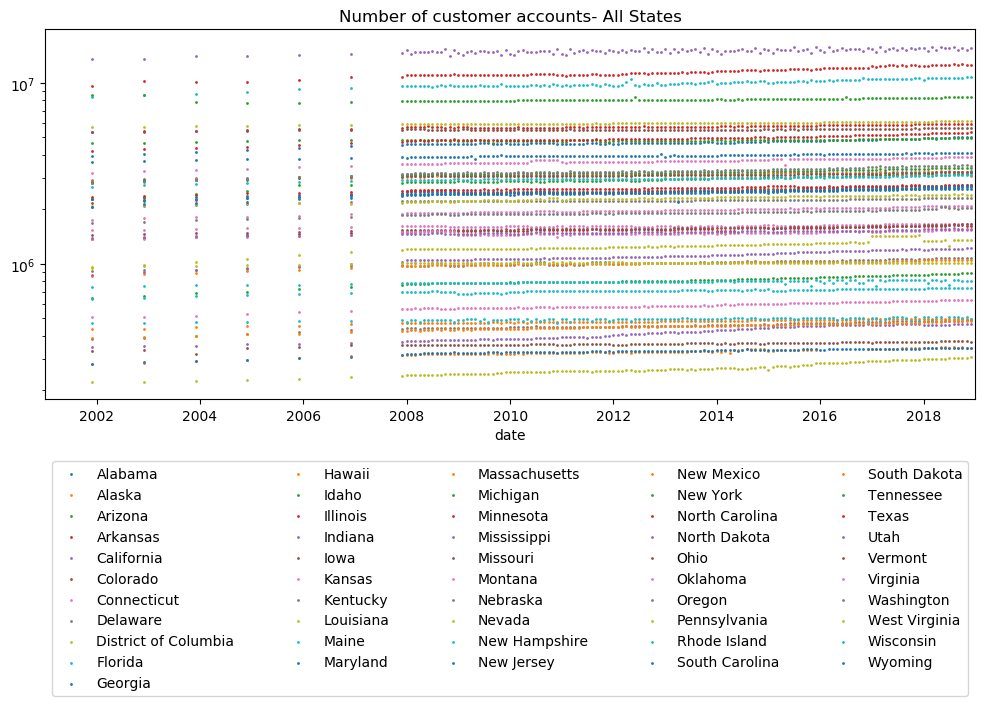

<Figure size 1200x480 with 0 Axes>

In [43]:
variable='Number of customer accounts'

plot_scatter_variable_all_states(df_all,variable)



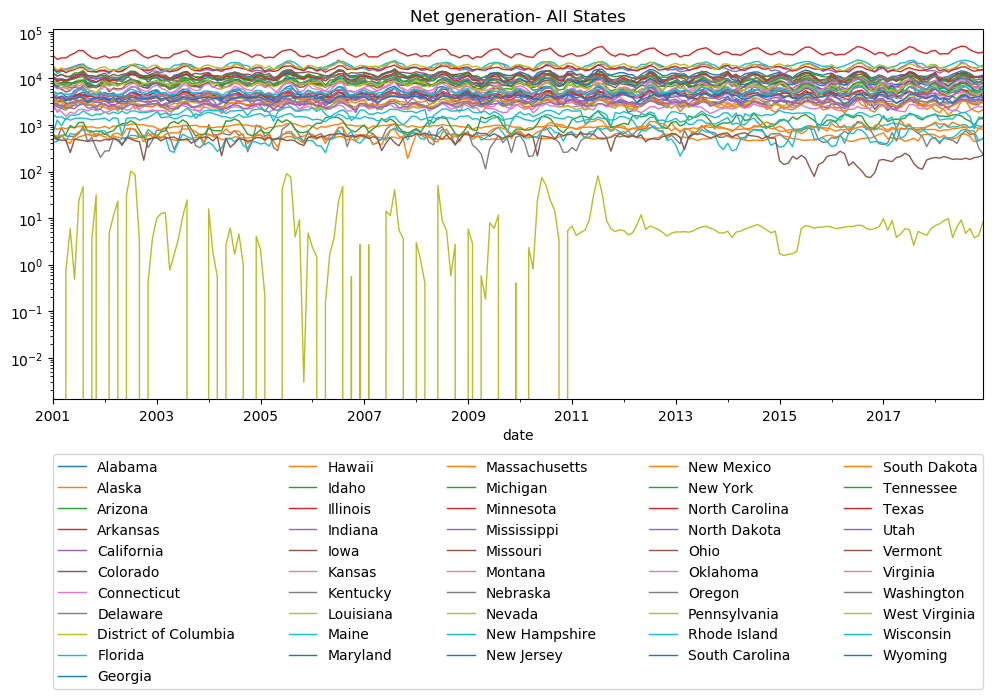

<Figure size 1200x480 with 0 Axes>

In [44]:
variable='Net generation'

plot_variable_all_states(df_all,variable)

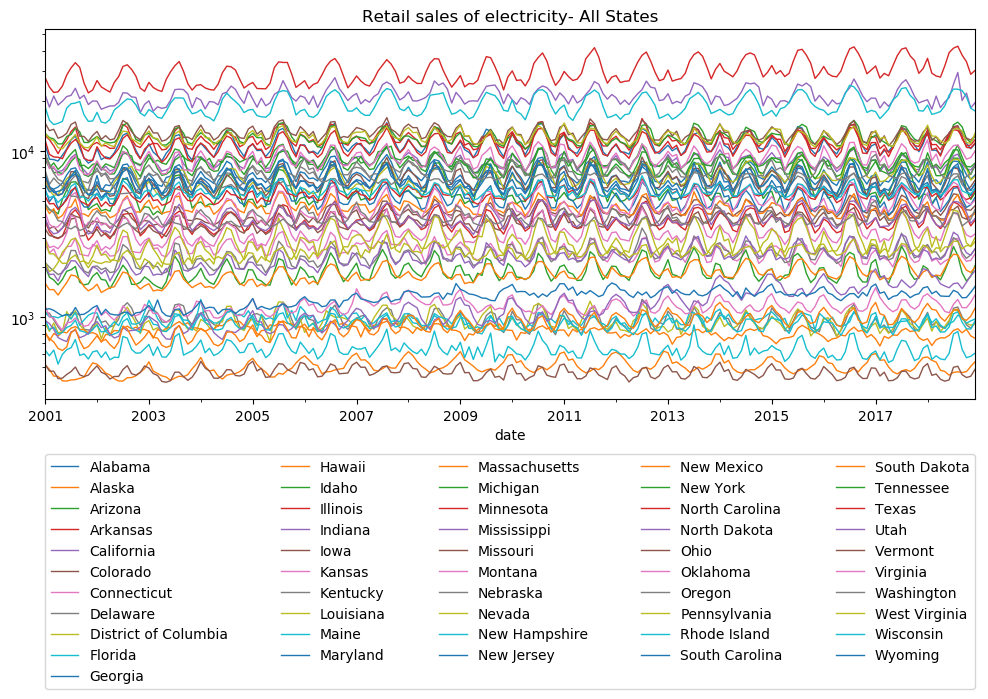

<Figure size 1200x480 with 0 Axes>

In [45]:
variable='Retail sales of electricity'

plot_variable_all_states(df_all,variable)

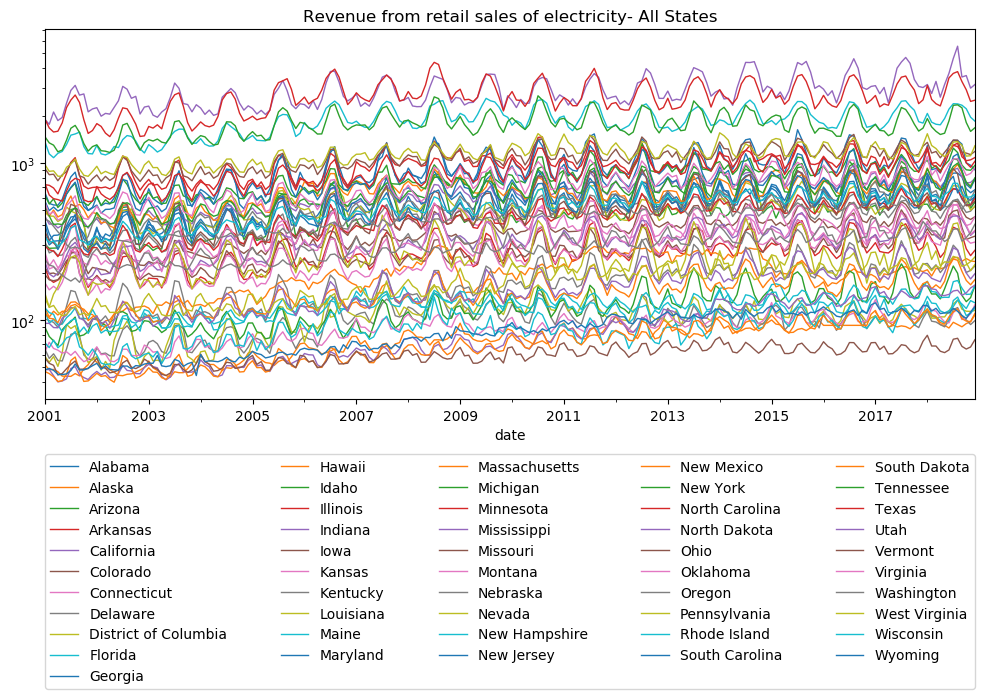

<Figure size 1200x480 with 0 Axes>

In [46]:
variable='Revenue from retail sales of electricity'

plot_variable_all_states(df_all,variable)

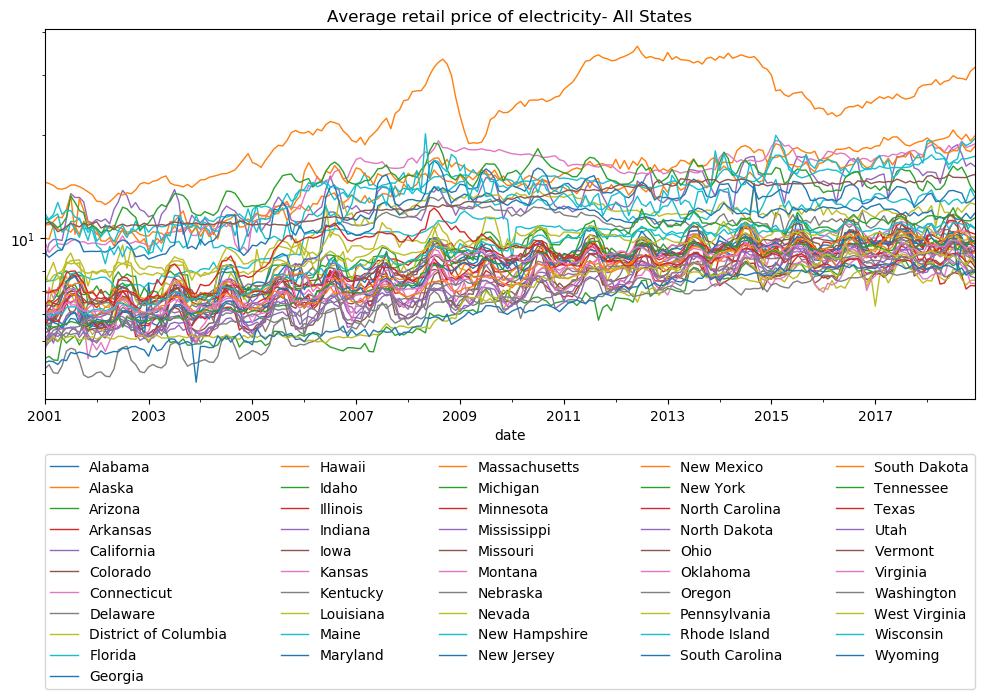

<Figure size 1200x480 with 0 Axes>

In [47]:
variable='Average retail price of electricity'

plot_variable_all_states(df_all,variable)

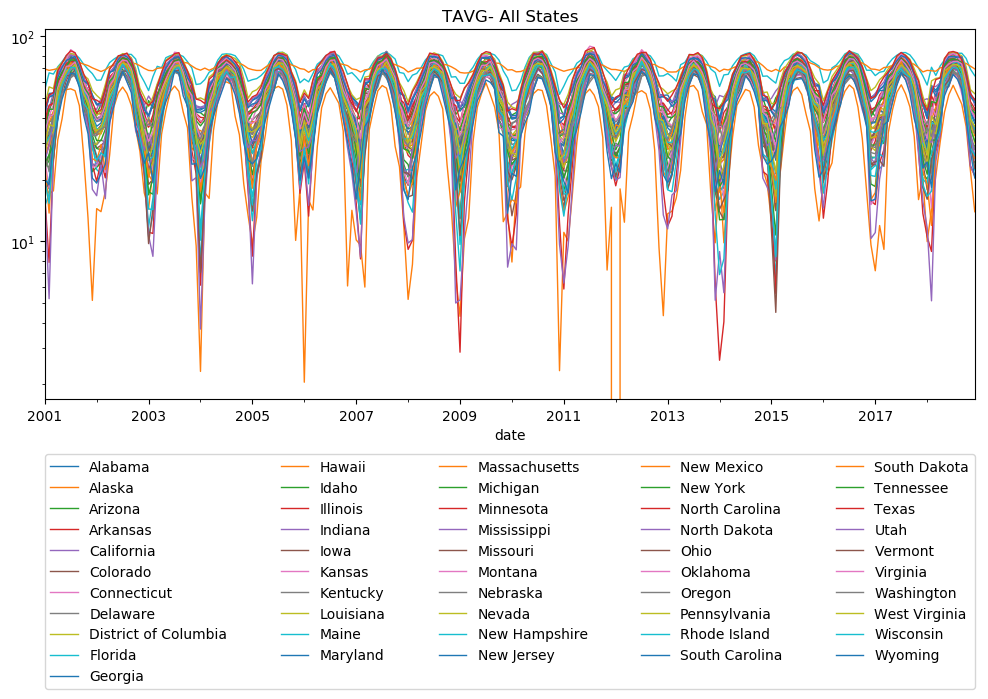

<Figure size 1200x480 with 0 Axes>

In [48]:
variable='TAVG'

plot_variable_all_states(df_all,variable)

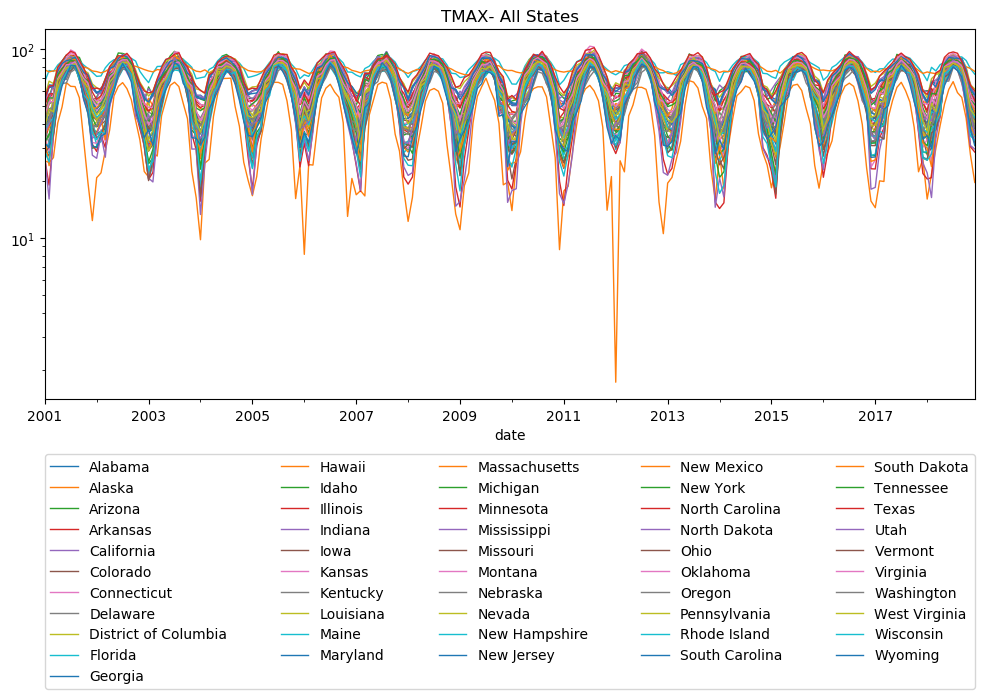

<Figure size 1200x480 with 0 Axes>

In [49]:
variable='TMAX'

plot_variable_all_states(df_all,variable)

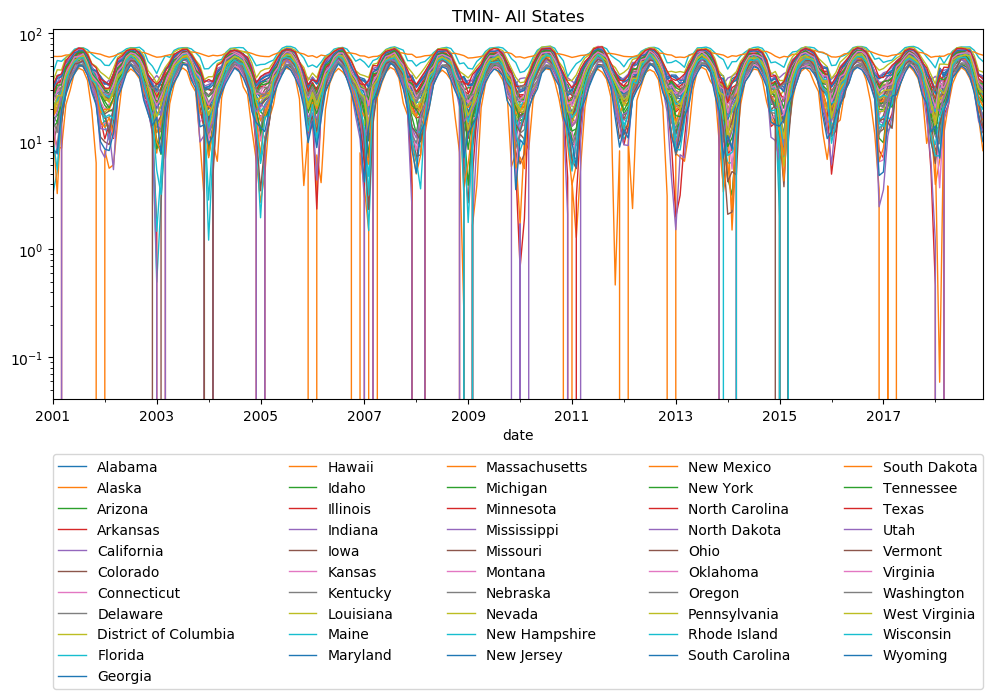

<Figure size 1200x480 with 0 Axes>

In [50]:
variable='TMIN'

plot_variable_all_states(df_all,variable)